# Машинное обучение, ФЭН ВШЭ, Козловский Евгений

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.114754970065754

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.997732088637395

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [9]:
from sklearn.tree import DecisionTreeRegressor

In [23]:
np.random.seed(5)
x = np.random.exponential(size = sample_size)[:, np.newaxis]
y = f(x).reshape(100,) + np.random.uniform(low=-1, high=1,size=100).reshape(100,)
clf = DecisionTreeRegressor()
clf.fit(x, y)
predictions = clf.predict(linspace[:, np.newaxis])

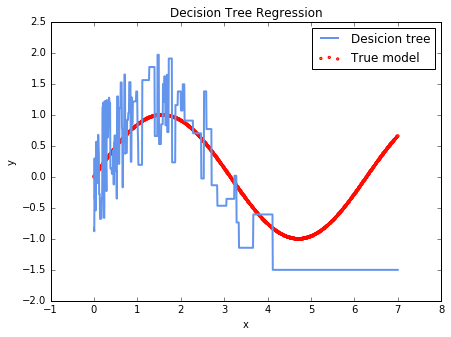

In [24]:
plt.figure(figsize = (7,5))
plt.scatter(linspace, f(linspace), s=5, edgecolor="red",
            c="darkorange", label="True model")
plt.plot(linspace, predictions, color="cornflowerblue",
         label="Desicion tree", linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

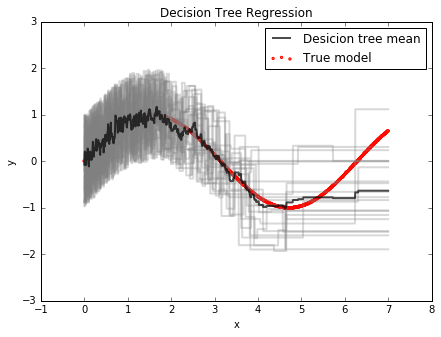

In [28]:
np.random.seed(5)
predictions_sum = np.zeros(1000)
plt.figure(figsize = (7,5))
plt.scatter(linspace, f(linspace), s=5, edgecolor="red",
            c="darkorange", label="True model")

for i in range(samples_num):
    x = np.random.exponential(size = sample_size)[:, np.newaxis]
    y = f(x).reshape(100,) + np.random.uniform(low=-1, high=1,size=100).reshape(100,)
    clf = DecisionTreeRegressor()
    clf.fit(x, y)
    predictions_sum += clf.predict(linspace[:, np.newaxis])
    plt.plot(linspace, clf.predict(linspace[:, np.newaxis]), color="gray",
         alpha=0.3, linewidth=2)
plt.plot(linspace, predictions_sum/samples_num, color="black", label="Desicion tree mean",
         alpha=0.7, linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

10

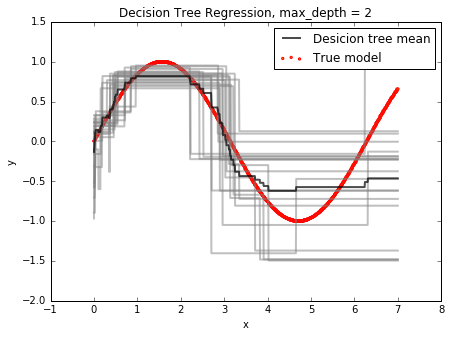

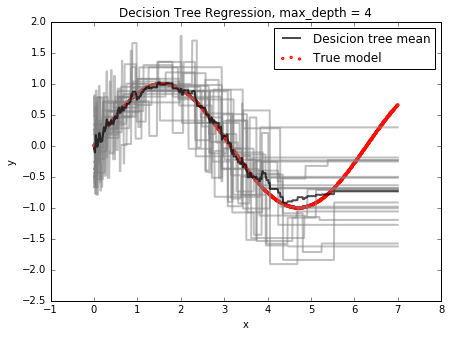

In [30]:
np.random.seed(5)
for j in [2,4]:
    predictions_sum = np.zeros(1000)
    plt.figure(figsize = (7,5))
    plt.scatter(linspace, f(linspace), s=5, edgecolor="red",
            c="darkorange", label="True model")
    for i in range(samples_num):
        x = np.random.exponential(size = sample_size)[:, np.newaxis]
        y = f(x).reshape(100,) + np.random.uniform(low=-1, high=1,size=100).reshape(100,)
        clf = DecisionTreeRegressor(max_depth=j)
        clf.fit(x, y)
        predictions_sum += clf.predict(linspace[:, np.newaxis])
        plt.plot(linspace, clf.predict(linspace[:, np.newaxis]), color="gray",
         alpha=0.5, linewidth=2)
    plt.plot(linspace, predictions_sum/samples_num, color="black", label="Desicion tree mean",
         alpha=0.7, linewidth=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Decision Tree Regression, max_depth = "+str(j))
    plt.legend()
    plt.show()

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

Характерная черта для всех алгоритмов: имеет место значительное смещение алгоритмов при  $x \in [5,5; 7]$, поскольку данные значения признака мало представлены в обучающей выборке в силу специфики экспоненциального распределения. Алгоритму, полученнному путем усреднения решающих деревьев с ограничением 2 на глубину дерева, присуща наибольшая степень смещенности. У алгоритма без ограничения и с ограничением 4 в целом не наблюдается значительного смещения (в данном случае речь идет о промежутке $x \in [0; 5,5]$), но тем не менее у алгоритма с ограничением 4 степень смещения наименьшая (разница между степенью смещенностью алгоритмов особенно заметна при $x \in [0; 2,5]$. С учетом этого, а также того, что при обучении алгоритмов к функции f(x) мы добавляли случайный шум, можно сказать, что алгоритм с ограниченим 4 в наименьшей степени склонен к переобучению.

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

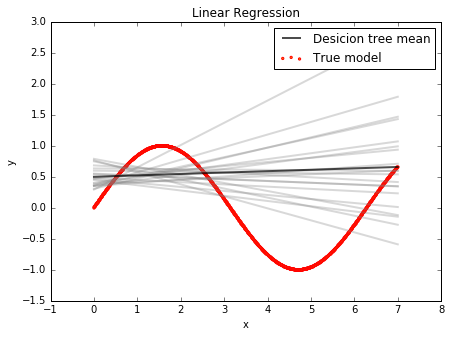

In [32]:
np.random.seed(5)
predictions_sum = np.zeros(1000)
plt.figure(figsize = (7,5))
plt.scatter(linspace, f(linspace), s=5, edgecolor="red",
            c="darkorange", label="True model")

for i in range(samples_num):
    x = np.random.exponential(size = sample_size)[:, np.newaxis]
    y = f(x).reshape(100,) + np.random.uniform(low=-1, high=1,size=100).reshape(100,)
    clf = LinearRegression()
    clf.fit(x, y)
    predictions_sum += clf.predict(linspace[:, np.newaxis])
    plt.plot(linspace, clf.predict(linspace[:, np.newaxis]), color="gray",
         alpha=0.3, linewidth=2)
plt.plot(linspace, predictions_sum/samples_num, color="black", label="Desicion tree mean",
         alpha=0.7, linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Regression")
plt.legend()
plt.show()

Очевидно, что полученное усредненное уравнение регресиии - неадекватная аппроксимация исходной функции: смещение алгоритма очень велико. Тем не менее, если бы регрессии обучались на равномерно распределенных данных, а не на экспоненциально распределенных, то усредненная регрессия лучше описывала бы функцию f(x).

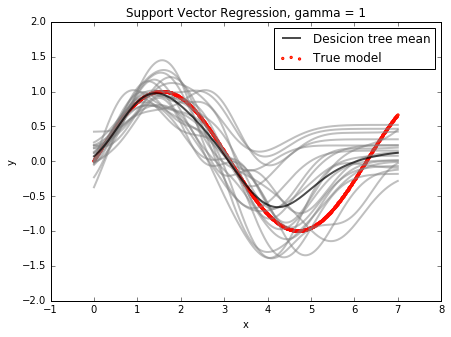

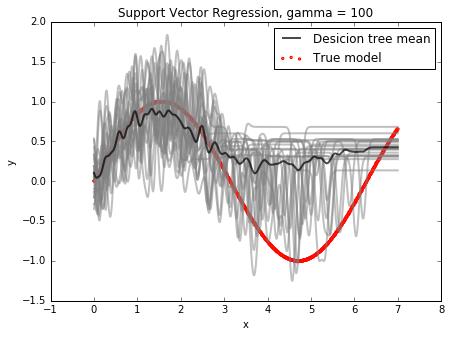

In [33]:
np.random.seed(5)
for j in [1,100]:
    predictions_sum = np.zeros(1000)
    plt.figure(figsize = (7,5))
    plt.scatter(linspace, f(linspace), s=5, edgecolor="red",
            c="darkorange", label="True model")
    for i in range(samples_num):
        x = np.random.exponential(size = sample_size)[:, np.newaxis]
        y = f(x).reshape(100,) + np.random.uniform(low=-1, high=1,size=100).reshape(100,)
        clf = SVR(kernel='rbf', gamma=j)
        clf.fit(x, y)
        predictions_sum += clf.predict(linspace[:, np.newaxis])
        plt.plot(linspace, clf.predict(linspace[:, np.newaxis]), color="gray",
         alpha=0.5, linewidth=2)
    plt.plot(linspace, predictions_sum/samples_num, color="black", label="Desicion tree mean",
         alpha=0.7, linewidth=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Support Vector Regression, gamma = "+str(j))
    plt.legend()
    plt.show()

При $\gamma = 1$ полученный усредненный алгоритм хорошо описывает исходную зависимость при $x \in [0; 4]$ (смещение практически нулевое), однако при $x \in [4; 7]$ наблюдается значительное смещение. Опять же, это объясняется тем, обучающая выборка взята не из равномерного распределения, и, соответственно, большая часть иксов сосредоточена в промежутке $x \in [0; 4]$ (экспоненциальное распределение).

При $\gamma = 100$ алгоритм сильно переобучился и в значительной степени подстроился под конкретные шумы. Смещение гораздо выше, чем при $\gamma = 1$.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [2]:
import pandas as pd
mushroom=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', names = 
            ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size',
            'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 
            'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type',
            'spore-print-color', 'population', 'habitat']) #все признаки категориальные
tic_rac_toe=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', names =
            ['top-left-square', 'top-middle-square', 'top-right-square', 'middle-left-square', 'middle-middle-square', 
            'middle-right-square', 'bottom-left-square', 'bottom-middle-square', 'bottom-right-square', 
            'class'])#все признаки категориальные
cars=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names = 
            ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])# есть вещественные признаки (целочисленные):
#doors и persons, однако данные признаки могут принимать значения 5-more и more, соответственно, поэтому нужно создать отдельные
#дамми-переменные для этих значений (стоит отметить, что линейной зависимости между старым признаком и новой дамми-переменной не будет).
nursery=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', names = 
            ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'class'])
#есть вещественный признак (целочисленный):children, однако данный признак может принимать значения more, поэтому нужно создать отдельную
#дамми-переменную для этого значения (стоит отметить, что линейной зависимости между старым признаком и новой дамми-переменной не будет).

/Users/macbook/anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


##### Все признаки вещественные:

In [3]:
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
from sklearn.preprocessing import LabelEncoder
mushroom1 = mushroom.apply(LabelEncoder().fit_transform)
y_mushroom = mushroom1.iloc[:,0]
mushroom1 = mushroom1.iloc[:, 1:]
mushroom1.head()

,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1


In [5]:
tic_rac_toe.head()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [6]:
tic_rac_toe1 = tic_rac_toe.apply(LabelEncoder().fit_transform)
y_tic_rac_toe = tic_rac_toe1.iloc[:, -1]
tic_rac_toe1 = tic_rac_toe1.iloc[:, :tic_rac_toe1.shape[1]-1]
tic_rac_toe1.head()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square
0,2,2,2,2,1,1,2,1,1
1,2,2,2,2,1,1,1,2,1
2,2,2,2,2,1,1,1,1,2
3,2,2,2,2,1,1,1,0,0
4,2,2,2,2,1,1,0,1,0


In [7]:
y_cars = cars.iloc[:, -1]
cars.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [8]:
def cat_car(t):
    if t in ['unacc', 'acc']:
        return 0
    elif t in ['good', 'vgood']:
        return 1
y_cars = y_cars.apply(cat_car)
cars1 = cars.iloc[:, :cars.shape[1]-1]
cars1 = cars1.apply(LabelEncoder().fit_transform)
cars1.head()

,buying,maint,doors,persons,lug_boot,safety
0,3,3,0,0,2,1
1,3,3,0,0,2,2
2,3,3,0,0,2,0
3,3,3,0,0,1,1
4,3,3,0,0,1,2


In [9]:
y_nursery = nursery.iloc[:, -1]
nursery.head()

,parents,has_nurs,form,children,housing,finance,social,health,class
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


In [10]:
def cat_nurs(t):
    if t in ['not_recom', 'recommend']:
        return 0
    elif t in ['very_recom', 'priority', 'spec_prior']:
        return 1

y_nursery = y_nursery.apply(cat_nurs)
nursery1 = nursery.iloc[:, :nursery.shape[1]-1]
nursery1 = nursery1.apply(LabelEncoder().fit_transform)
nursery1.head()

,parents,has_nurs,form,children,housing,finance,social,health
0,2,3,0,0,0,0,0,2
1,2,3,0,0,0,0,0,1
2,2,3,0,0,0,0,0,0
3,2,3,0,0,0,0,2,2
4,2,3,0,0,0,0,2,1


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

DecisionTreeClassifier для случая, когда все признаки вещественные

Accuracy по кросс-валидации для mushroom

In [12]:
np.random.seed(11)
np.mean(cross_val_score(X=mushroom1, y=y_mushroom, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score)))

0.96703203036962537

Accuracy по кросс-валидации для tic_rac_toe

In [13]:
np.mean(cross_val_score(X=tic_rac_toe1, y=y_tic_rac_toe, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score)))

0.72640622173991676

Accuracy по кросс-валидации для cars

In [14]:
np.mean(cross_val_score(X=cars1, y=y_cars, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score)))

0.94097166533012566

Accuracy по кросс-валидации для nursery

In [15]:
np.mean(cross_val_score(X=nursery1, y=y_nursery, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score)))

0.99969147700771965

#### Все признаки категориальные

In [16]:
mushroom2 = pd.get_dummies(mushroom.iloc[:, 1:])
tic_rac_toe2 = pd.get_dummies(tic_rac_toe.iloc[:, :tic_rac_toe.shape[1]-1])
cars2 = pd.get_dummies(cars.iloc[:, :cars.shape[1]-1])
nursery2 = pd.get_dummies(nursery.iloc[:, :nursery.shape[1]-1])

Accuracy по кросс-валидации для mushroom

In [17]:
np.random.seed(123)
np.mean(cross_val_score(X=mushroom2, y=y_mushroom, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score)))

0.96826568265682655

Accuracy по кросс-валидации для tic_rac_toe

In [18]:
np.mean(cross_val_score(X=tic_rac_toe2, y=y_tic_rac_toe, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score)))

0.81251220835594151

Accuracy по кросс-валидации для cars

In [19]:
np.mean(cross_val_score(X=cars2, y=y_cars, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score)))

0.83332665062817435

Accuracy по кросс-валидации для nursery

In [20]:
np.mean(cross_val_score(X=nursery2, y=y_nursery, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score)))

0.99969147700771965

#### Корректное разбиение признаков на категориальные и вещественные

С учетом того, что в датасетах mushroom и tic_rac_toe присутствуют только категориальные признаки, для них корректное разбиение - когда все признаки категориальные.

В датасетах cars и nursery имеются вещественные (целочисленные) признаки, но, при этом, среди значений данных признаков есть значение 'more' или 'more5'- их мы будем кодировать дамми переменными, а для старых признаков значения 'more' и 'more5' заменим нулями.

In [21]:
def cat_column(df, name1, name2):
    for i in range(df.shape[0]):
        if df[name1][i] in ['5more', 'more']:
            df[name2][i]=1
            df[name1][i]=0
        else:
            df[name2][i]=0

cars['doors_more'] = cars['doors']
cars['persons_more'] = cars['persons']
cat_column(cars, 'doors', 'doors_more')
cat_column(cars, 'persons', 'persons_more')
cars['doors'] = cars['doors'].astype('float32')
cars['persons'] = cars['persons'].astype('float32')   

cars_label1 = pd.get_dummies(cars.iloc[:, :2])
cars_label2 = pd.get_dummies(cars.iloc[:, 4:6])
cars_3 = pd.concat([cars_label1, cars_label2, cars['doors'], cars['doors_more'], cars['persons'], cars['persons_more']], axis=1)

In [22]:
def cat_column(df, name1, name2):
    for i in range(df.shape[0]):
        if df[name1][i] == 'more':
            df[name2][i]=1
            df[name1][i]=0
        else:
            df[name2][i]=0
nursery['children_more'] = nursery['children']
cat_column(nursery, 'children', 'children_more')
nursery['children'] = nursery['children'].astype('float32')   

nursery_label1 = pd.get_dummies(nursery.iloc[:, :3])
nursery_label2 = pd.get_dummies(nursery.iloc[:, 4:8])
nursery_3 = pd.concat([nursery_label1, nursery_label2, nursery['children'], nursery['children_more'] ], axis=1)

Accuracy по кросс-валидации для cars

In [23]:
np.mean(cross_val_score(X=cars_3, y=y_cars, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score)))

0.81996792301523658

Accuracy по кросс-валидации для nursery

In [25]:
np.mean(cross_val_score(X=nursery_3, y=y_nursery, estimator=DecisionTreeClassifier(), cv=10, scoring=make_scorer(accuracy_score)))

0.99953715602006521

__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Для датасета mushroom алгоритм демонстрирует практически идентичные уровни accuracy: 0.96703203036962537, когда все признаки вещественные, и 0.96826568265682655, когда все признаки категориальные (оно же корректное разбиение).

С датасетом tic_rac_toe ситуация иная: accuracy принимает значение 0.72640622173991676, когда все признаки вещественные, и 0.81251220835594151, когда все признаки категориальные (оно же корректное разбиение). Все довольно логично.

Для датасета cars получились следующие результаты: 0.94097166533012566, когда все признаки вещественные, 0.83332665062817435, когда все признаки категориальные и 0.81996792301523658 при теоретически корректном разбиении. В принципе, разница между вторым и третьим случаем не такая уж и большая. Но самое интересное то, что при вещественных признаках accuracy гораздо выше, чем в двух других случаях. Почему же так получилось? Дело в том, что подавляющее большинство признаков хоть и категориальные, но, при этом, значения данных признаков можно проранжировать (vhigh high small med и так далее), а с учетом того, что LabelEncoder как раз таки ранжирует значения признаков, придавая им целые значения (причем не важно, в убывающем или возрастающем порядке), то получается, что LabelEncoder лучше учитывает специфику признаков, показывая тем самым более высокую точность.

Для датасета nursery accuracy для первых двух случаев совпало: 0.99969147700771965 -  для последнего случая accuracy=0.99953715602006521. Разница совсем не существенная и скорее всего объясняется случайной составляющей (random seed)

В результатах есть некоторый элемент случайности (random seed). Для ее исключения можно обучать и тестировать одни и те алгоритмы для разных значений seed.

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [42]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

In [43]:
win = pd.read_csv('winequality-red.csv', sep=';')
#вектор целевой переменной
y_win = win.iloc[:, -1]
#матрица признаков
win = win.iloc[:, :-1]
win.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


Проверим исходный датафрейм на наличие пропусков

In [44]:
win.isnull().sum().sum()+y_win.isnull().sum().sum()

0

Accuracy по кросс-валидации для DecisionTreeClassifier

In [53]:
np.random.seed(143220)
np.mean(cross_val_score(X=win, y=y_win, estimator=DecisionTreeClassifier(), cv=3, scoring=make_scorer(accuracy_score)))

0.44655923574917677

Accuracy по кросс-валидации для BaggingClassifier со 100 деревьями

In [54]:
np.mean(cross_val_score(X=win, y=y_win, estimator=BaggingClassifier(n_estimators=100), cv=3, scoring=make_scorer(accuracy_score)))

0.56043516734541443

Accuracy по кросс-валидации для BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков

In [55]:
np.mean(cross_val_score(X=win, y=y_win, estimator=BaggingClassifier(n_estimators=100, max_features=0.5), cv=3, scoring=make_scorer(accuracy_score)))

0.56106296656999233

Accuracy по кросс-валидации для RandomForestClassifier со 100 деревьями

In [56]:
np.mean(cross_val_score(X=win, y=y_win, estimator=RandomForestClassifier(n_estimators=100), cv=3, scoring=make_scorer(accuracy_score)))

0.56669858617987334

#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [528]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(win, y_win, test_size=0.3, random_state=60)

In [529]:
n_estimators = np.arange(100, 5100, 100)

/Users/macbook/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


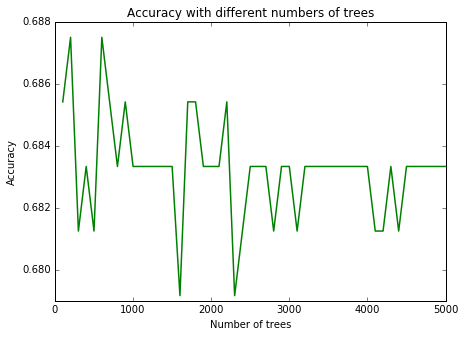

In [539]:
np.random.seed(349)
from sklearn.metrics import accuracy_score
spisok = []
clf = RandomForestClassifier(warm_start=True)
for i in n_estimators:
    clf.set_params(n_estimators=i)
    clf.fit(X_train, y_train)
    spisok.append(accuracy_score(y_test, clf.predict(X_test)))
plt.figure(figsize = (7,5))
plt.plot(n_estimators, spisok, color="green", 
          linewidth=1.5)
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.title('Accuracy with different numbers of trees')
plt.legend()
plt.show()

Из графика видно, что с увеличением количества деревьев не наблюдается переобучения алгоритма: accuracy остается на более-менее стабильном уровне.

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

При выполнения задания использовался код из https://elitedatascience.com/keras-tutorial-deep-learning-in-python

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using Theano backend.


Предобработка данных

В данном датасете каждая матрица размерности (28,28) - числовое представление изображения с рукописной цифрой (28 пикселей x 28 пикселей).

Посмотрим на размерность x_train

In [3]:
x_train.shape

(60000, 28, 28)

Всего у нас имеется 60000 объектов в обучающей выборке

Глубина каждого изображения составляет 1, но мы должны это явным образом указать. Для этого нам потребуется решейпнуть x_train и x_test

In [4]:
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

Проверка:

In [5]:
x_train.shape

(60000, 1, 28, 28)

Также нужно отнормировать числа, предварительно переведя их в формат float32

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255

Посмотрим на размерность вектора целевых переменных, в качестве которых выступают цифры от 0 до 9 (классы)

In [7]:
y_train.shape

(60000,)

Целевые переменные представлены в виде одномерного вектора

Для обучения нейронной сети нам необходимо перевести i-ое значение в вектор, состоящий из нулей и одной единицы (соответствующей прогнозируемому классу)

In [8]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

Проверка

In [9]:
y_train.shape

(60000, 10)

In [24]:
y_train[0]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

Нейронная сеть будет состоять из 4 Dense слоев: входного (input), двух скрытых (hidden) и выходного (output). В качестве функции активации для первых трех слоев используется relu, для выходного - sigmoid.

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
#инициализируем модель
model3 = Sequential()
#создаем входной Dense слой со 100 нейронами: input_shape=(1,28,28), где 1-глубина, 28-ширина и высота изображения.
model3.add(Dense(100, input_shape=(1,28,28), activation='relu'))
#добавляем скрытые слои
model3.add(Dense(100, activation='relu'))
model3.add(Dense(100, activation='relu'))
#решейпим output 3-его слоя для корректной работы выходного слоя.
model3.add(Flatten())
#Выходной слой будет выдавать 10 значений, поскольку у нас всего 10 классов (цифр)
model3.add(Dense(10, activation='sigmoid'))

Определяем параметры обучения и метрику качества

In [610]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Обучаем модель

In [611]:
model3.fit(x_train, y_train, verbose=1)

Epoch 1/10
60000/60000 [==============================] - 22s - loss: 0.0534 - acc: 0.9823    
Epoch 2/10
60000/60000 [==============================] - 19s - loss: 0.0307 - acc: 0.9900    
Epoch 3/10
60000/60000 [==============================] - 17s - loss: 0.0271 - acc: 0.9913    
Epoch 4/10
60000/60000 [==============================] - 18s - loss: 0.0246 - acc: 0.9920    
Epoch 5/10
60000/60000 [==============================] - 17s - loss: 0.0228 - acc: 0.9925    
Epoch 6/10
60000/60000 [==============================] - 19s - loss: 0.0211 - acc: 0.9931    
Epoch 7/10
60000/60000 [==============================] - 17s - loss: 0.0198 - acc: 0.9934    
Epoch 8/10
60000/60000 [==============================] - 16s - loss: 0.0186 - acc: 0.9939    
Epoch 9/10
60000/60000 [==============================] - 19s - loss: 0.0173 - acc: 0.9943    
Epoch 10/10
60000/60000 [==============================] - 17s - loss: 0.0163 - acc: 0.9947    


Оцениваем качество модели на тестовой выборке

In [612]:
score, acc = model3.evaluate(x_test, y_test,)
print('Test score:', score)
print('Test accuracy:', acc)

 9824/10000 [============================>.] - ETA: 0sTest score: 0.0259164938672
Test accuracy: 0.99214999733


__10 (2 балл)__ Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке.

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

Добавим по 2 слоя Convolution2D и MaxPooling2D.

In [16]:
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
K.set_image_dim_ordering('th')
model_nn = Sequential()
model_nn.add(Dense(100, input_shape=(1,28,28), activation='relu'))
#вектор (32, 3, 3) в слое Convolution2D соответствует вектору параметров (количество фильтров, количество строк в сверточном ядре,
#количество столбцов в сверточном ядре)
model_nn.add(Convolution2D(32, 3, 3, activation='relu'))
#вектор (2,2) - размер максимального pooling-окна
model_nn.add(MaxPooling2D(pool_size=(2,2)))
model_nn.add(Convolution2D(32, 3, 3, activation='sigmoid'))
model_nn.add(MaxPooling2D(pool_size=(2,2)))
model_nn.add(Dense(100, activation='relu'))
model_nn.add(Flatten())
model_nn.add(Dense(10, activation='sigmoid'))

In [17]:
model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model_nn.fit(x_train, y_train, verbose=1)

Epoch 1/10
60000/60000 [==============================] - 338s - loss: 0.0485 - acc: 0.9840   
Epoch 2/10
60000/60000 [==============================] - 326s - loss: 0.0137 - acc: 0.9954   
Epoch 3/10
60000/60000 [==============================] - 895s - loss: 0.0097 - acc: 0.9968   
Epoch 4/10
60000/60000 [==============================] - 315s - loss: 0.0074 - acc: 0.9975   
Epoch 5/10
60000/60000 [==============================] - 316s - loss: 0.0056 - acc: 0.9981   
Epoch 6/10
60000/60000 [==============================] - 318s - loss: 0.0046 - acc: 0.9984   
Epoch 7/10
60000/60000 [==============================] - 341s - loss: 0.0034 - acc: 0.9989   
Epoch 8/10
60000/60000 [==============================] - 373s - loss: 0.0027 - acc: 0.9991   
Epoch 9/10
60000/60000 [==============================] - 370s - loss: 0.0022 - acc: 0.9993   
Epoch 10/10
60000/60000 [==============================] - 396s - loss: 0.0018 - acc: 0.9994   


In [19]:
score, acc = model_nn.evaluate(x_test, y_test,)
print('Test score:', score)
print('Test accuracy:', acc)

 9984/10000 [============================>.] - ETA: 0sTest score: 0.00987887108295
Test accuracy: 0.99710999527


Значение accuracy выросло по сравнению с предыдущим пунктом.

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

Добавим два слоя Dropout с rate=0,25, следующих за слоями MaxPooling2D

In [20]:
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras import backend as K
K.set_image_dim_ordering('th')
model_drop = Sequential()
model_drop.add(Dense(100, input_shape=(1,28,28), activation='relu'))
model_drop.add(Convolution2D(32, 3, 3, activation='relu'))
model_drop.add(MaxPooling2D(pool_size=(2,2)))
model_drop.add(Dropout(0.25))
model_drop.add(Convolution2D(32, 3, 3, activation='sigmoid'))
model_drop.add(MaxPooling2D(pool_size=(2,2)))
model_drop.add(Dropout(0.25))
model_drop.add(Dense(100, activation='relu'))
model_drop.add(Flatten())
model_drop.add(Dense(10, activation='sigmoid'))

In [21]:
model_drop.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model_drop.fit(x_train, y_train, verbose=1)

Epoch 1/10
60000/60000 [==============================] - 423s - loss: 0.0594 - acc: 0.9805   
Epoch 2/10
60000/60000 [==============================] - 402s - loss: 0.0185 - acc: 0.9938   
Epoch 3/10
60000/60000 [==============================] - 405s - loss: 0.0141 - acc: 0.9952   
Epoch 4/10
60000/60000 [==============================] - 390s - loss: 0.0115 - acc: 0.9961   
Epoch 5/10
60000/60000 [==============================] - 386s - loss: 0.0102 - acc: 0.9965   
Epoch 6/10
60000/60000 [==============================] - 393s - loss: 0.0088 - acc: 0.9970   
Epoch 7/10
60000/60000 [==============================] - 900s - loss: 0.0081 - acc: 0.9972   
Epoch 8/10
60000/60000 [==============================] - 407s - loss: 0.0072 - acc: 0.9976   
Epoch 9/10
60000/60000 [==============================] - 409s - loss: 0.0067 - acc: 0.9977   
Epoch 10/10
60000/60000 [==============================] - 412s - loss: 0.0062 - acc: 0.9978   


In [627]:
score, acc = model_drop.evaluate(x_test, y_test,)
print('Test score:', score)
print('Test accuracy:', acc)

 9888/10000 [============================>.] - ETA: 0sTest score: 0.0366499583006
Test accuracy: 0.988279999065


Как видим, большего качества при добавлении двух слоев Dropout добиться все же не удалось, поскольку accuracy на тестовой выборке снизился по сравнению с предыдущим пунктом. Что же касается процесса обучения, здесь наблюдается схожая тенденция: на каждом epoch accuracy снизился.

Резюмируем вышесказанное: использование регуляризации в виде добавления слоев Dropout в данном случае себя не оправдало.